**CBOW 모델의 문제점**  
- 말뭉치에 포함된 어휘 수가 많아지면 계산량도 커진다.→계산 시간도 길어짐  
<br>

**개선점**  
1) Embedding 계층 새로 도입  
2) 네거티브 샘플링이라는 손실 함수 도입

## 1. word2vec 개선 ①

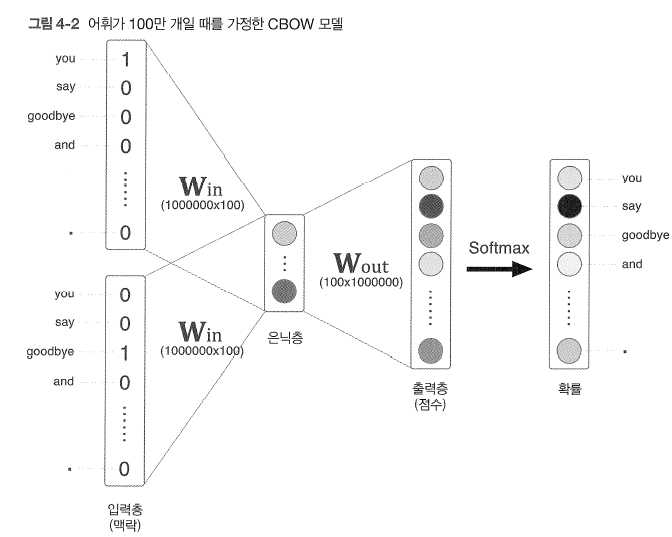

입력층과 출력층에 각 100만 개의 뉴런 존재  
→ 1) **입력층의 원핫 표현(어휘 수 많아져 벡터 크기 커짐)**과 가중치 행렬 W_in의 곱 계산 : 계산 자원 사용 ↑ → **Embedding 계층 도입!**  
→ 2) 은닉층과 가중치 행렬 W_out의 곱 및 Softmax 계층의 계산 : 계산량 증가 → **손실함수 네거티브 샘플링 도입**

### 1) Embedding 계층
**단어 ID에 해당하는 행을 추출하는 계층**
- '단어 임베딩'에서 유래  
- 단어 임베딩, 즉 분산 표현을 Embedding 계층에 저장함

### 2) Embedding 계층 구현

In [1]:
import numpy as np
W = np.arange(21).reshape(7,3)
print(W)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]


In [2]:
print(W[2])
print(W[5]) #특정 행을 추출하기 위해서는 원하는 행 명시하면 끝!

[6 7 8]
[15 16 17]


In [3]:
idx = np.array([1,0,3,0])
W[idx] # 여러 행을 한꺼번에 추출하기 위해서는 원하는 행 번호들을 배열에 명시하면 끝!

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [4]:
# Embedding 계층의 forward() 구현
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

In [5]:
# Embedding 계층의 backward() 구현
def backward(self, dout):
        dW, = self.grads # dW : 가중치 기울기
        dW[...] = 0 # dW의 원소를 0으로 덮어씀(dW의 형상을 유지한 채 그 원소들을 0으로 덮어쓰는 것!)
        np.add.at(dW, self.idx, dout) # 이전 층에서 전해진 기울기 dout를 idx 번째 행에 할당
        return None

Embedding 계층의 **순전파** : 가중치 W의 특정 행을 추출해 그대로 다음 층으로 흘려보냄  
<br>
Embedding 계층의 **역전파** : 출력 측 층으로부터 전해진 기울기를 입력 측 층으로 그대로 흘려주냄.  
                           → 출력 측 층에서 전해진 기울기를 가중치 기울기 dW의 특정 행(idx번째 행)에 설정

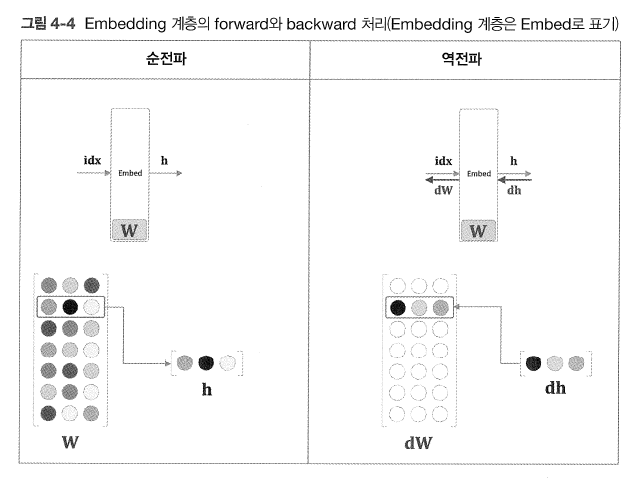

backward() 구현에서 발생하는 문제점 : **idx 원소가 중복될 때 발생**  
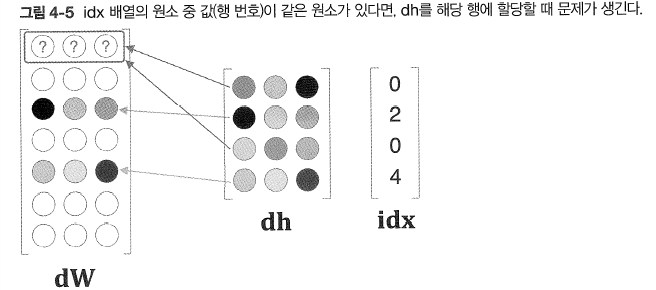  
- dh의 각 행 값을 idx가 가리키는 장소에 할당하면 dW의 0번째 행에 2개의 값이 할당된다.  
→ 해결) '할당'이 아닌 '더하기'를 해야 한다! 즉, dh의 각 행의 값을 dW의 해당 행에 더해주는 것이다!  

In [7]:
# backward() 수정
def backward(self,dout) :
    dW, = self.grads
    dw[...] = 0
    
    for i, word_id in enumerate(self.idx) :
        dW[word_id] += dout[i]
    # 혹은 np.add.at(dW,self.idx,dout)
    
    return None

### 이제 word2vec(CBOW) 모델 구현 시 입력 측 MatMul 계층을 Embedding 계층으로 전환 가능!

## 2. word2vec 개선 ② : 네거티브 샘플링(부정적 샘플링)
Softmax 대신 네거티브 샘플링 이용 : 어휘가 많아져도 계산량을 낮은 수준에서 일정하게 억제 가능

### 1) 은닉층 이후 계산의 문제점
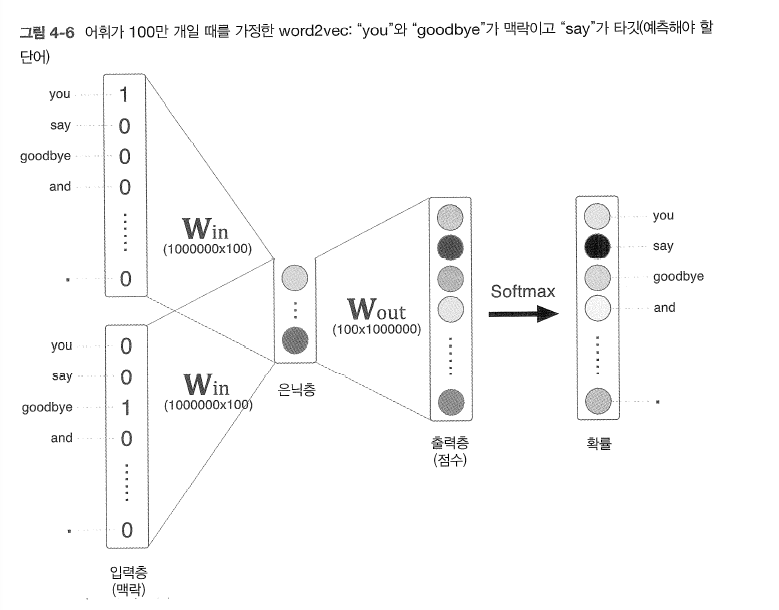  
계산 오래 걸리는 곳  
1) 은닉층의 뉴런과 가중치 행렬 W_out의 곱 : 거대 행렬을 곱하는 문제 - 시간, 메모리 문제  
2) Softmax 계층의 계산 : 어휘가 많아지면 Softmax 계산량 증가  
⇒ **"가벼운" 계산**이 필요!

### 2) 다중 분류에서 이진 분류로
네거티브 샘플링 기법의 포인트 : **다중 분류**를 **이진 분류**로 근사하는 것  
- 다중 분류 : "맥락이 you와 goodbye일 때, 타깃 단어는 무엇입니까?"  
- 이진 분류(답: 예/아니오) : "맥락이 you와 goodbye일 때, 타깃 단어는 say입니까?"  
⇒ 근사하기 위해서는 출력층에 뉴런 하나만 준비하면 된다!! : 출력층의 뉴런이 **say의 점수를 출력**  


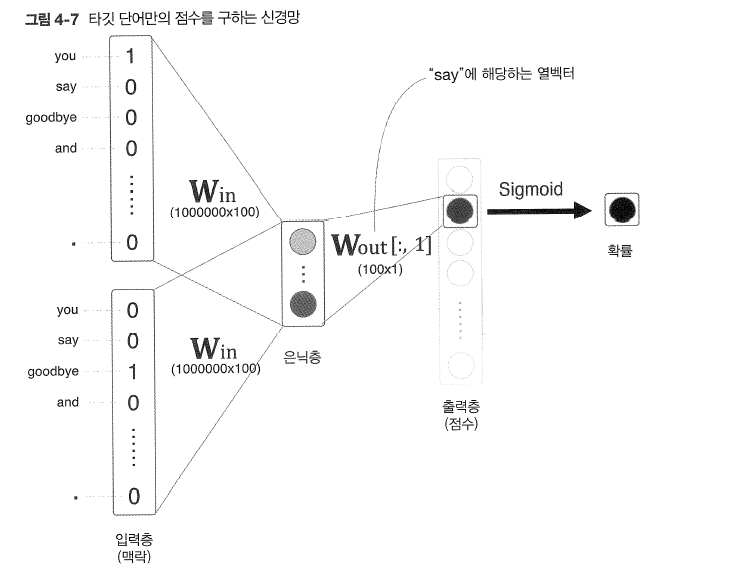

- 출력층의 뉴런 : 오직 한 개  
⇒ 은닉층과 W_out의 내적이 "say"에 해당하는 열만 추출 → 이 단어벡터와 은닉층 뉴런과의 내적만 계산하면 됨!  
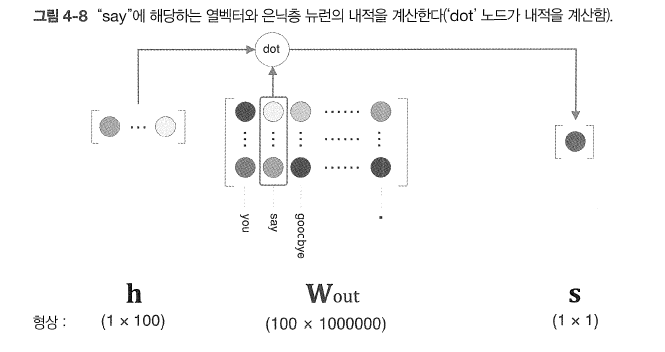

- W_out : 각 단어 ID의 단어 벡터가 열별로 저장 → 여기선 "say"에 해당하는 단어 벡터 추출
- 은닉층 뉴런 h
- 최종 점수 s

### 3) 시그모이드 함수와 교차 엔트로피 오차
**이진 분류 문제에서...**  
신경망 : 점수에 **시그모이드 함수** 적용해 확률로 변환  
손실 : 손실함수로 **교차 엔트로피 오차** 사용  

cf.**다중 분류 문제에서...**  
출력층 : 점수에 **소프트맥스 함수** 적용해 확률로 변환  
손실 : 손실함수로 **교차 엔트로피 오차** 사용

### 시그모이드 함수
$$y = \frac{1}{1+exp(-x)}$$

그래프 : 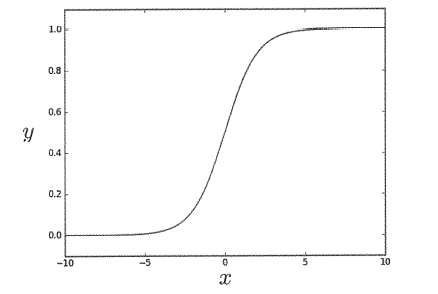

- S자 곡선 형태  
- 입력 값 x는 0~1 사이 실수로 변환  
- **시그모이드 함수의 출력 y를 "확률"로 해석 가능**

### 교차 엔트로피 오차
- 시그모이드 함수를 적용해 얻은 확률 y로부터 **손실** 계산  
$$L = -(tlogy+(1-t)log(1-y))$$

- y : 시그모이드 함수 출력  
- t : 정답 레이블(0 or 1)
 > t = 1 : 정답은 "Yes", -logy가 출력  
   t = 0 : 정답은 "No", -log(1-y)가 출력

#### Sigmoid 계층 & Cross Entropy Error 계층
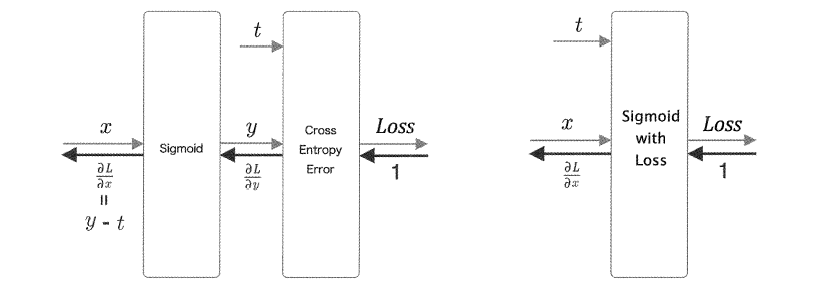

**역전파 y-t값**  
- t(정답 레이블) = 1 ⇒ y가 1(100%)에 가까울수록 오차가 줄어들고 1에서 멀어지면 오차가 커짐.
- 오차는 앞 계층으로 흘러가므로 오차가 크면 "크게" 학습하고 작으면 "작게" 학습

### 4) 다중 분류에서 이진 분류로(구현)
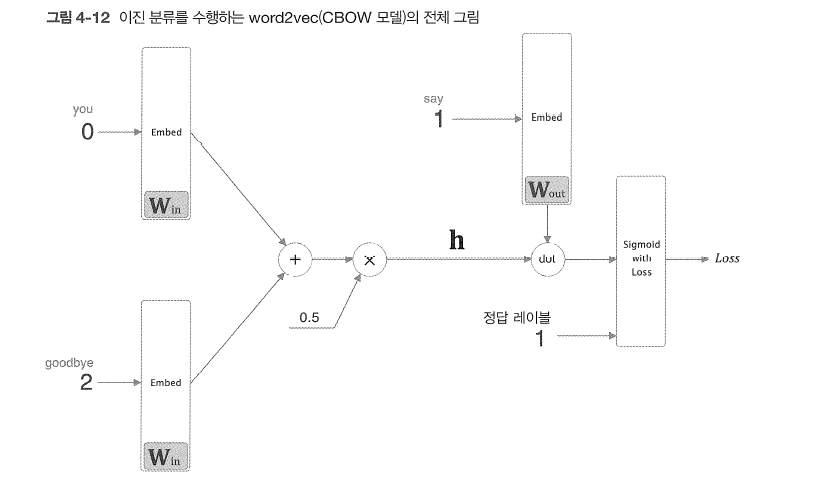

- **Embedding 계층** : 입력층에서 각각에 대응하는 단어 ID의 분산 표현을 추출하기 위해 사용 ⇒ 이전엔 MatMul 계층 사용  
- 손실 : 은닉층 뉴런 **h**와 **W_out**에서 "say"에 해당하는 단어 벡터와 내적 계산 후 출력을 **Sigmoid with Loss 계층**에 입력해 계산

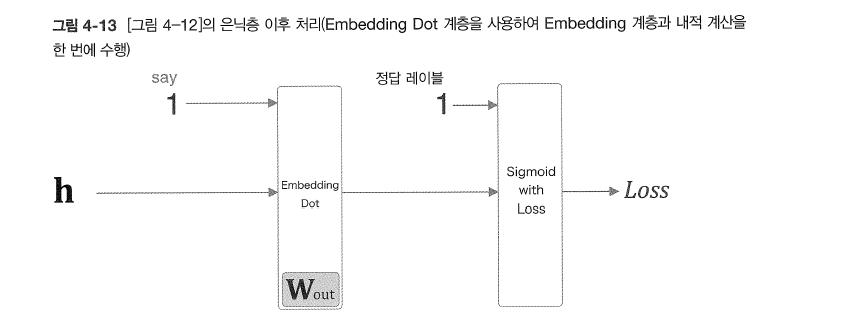

- **Embedding Dot 계층** : Embedding 계층과 'dot 연산(내적)'의 처리를 합친 계층

In [8]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W) # Embedding 계층
        self.params = self.embed.params # 매개변수 저장
        self.grads = self.embed.grads # 기울기 저장
        self.cache = None # 순전파 시 계산 결과를 잠시 유지하기 위한 변수

    def forward(self, h, idx): # 순전파
        target_W = self.embed.forward(idx) # idx : 단어 ID의 배열 → 데이터를 한꺼번에 처리하는 미니배치 처리 가정했기 때문
        out = np.sum(target_W * h, axis=1) # 내적 계산

        self.cache = (h, target_W)
        return out

    def backward(self, dout): # 역전파 : 순전파의 반대 순서로 기울기를 전달해 구현
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### 5) 네거티브 샘플링
**목표** : 긍정적인 예에 대해서는 Sigmoid 계층의 출력을 1에 가깝게 만들고 부정적 예에 대해서는 출력을 0에 가깝게 만드는 것  
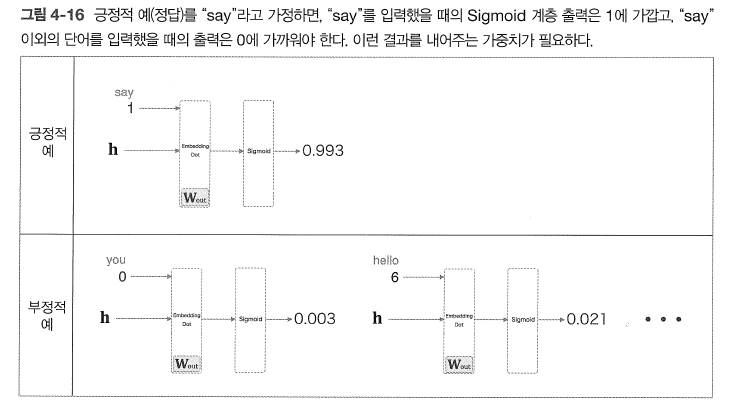

**방법** : 긍정적 예를 타깃으로 한 경우의 손실을 계산, 동시에 적은 수의 부정적 예를 샘플링해 마찬가지로 손실 계산 ⇒ 각 데이터의 손실을 더한 값을 최종 손실로 산출  
**주의** : 긍정적인 예의 Sigmoid with Loss 계층에 정답 레이블 = 1  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : 부정적인 예의 Sigmoid with Loss 계층에 정답 레이블 = 0
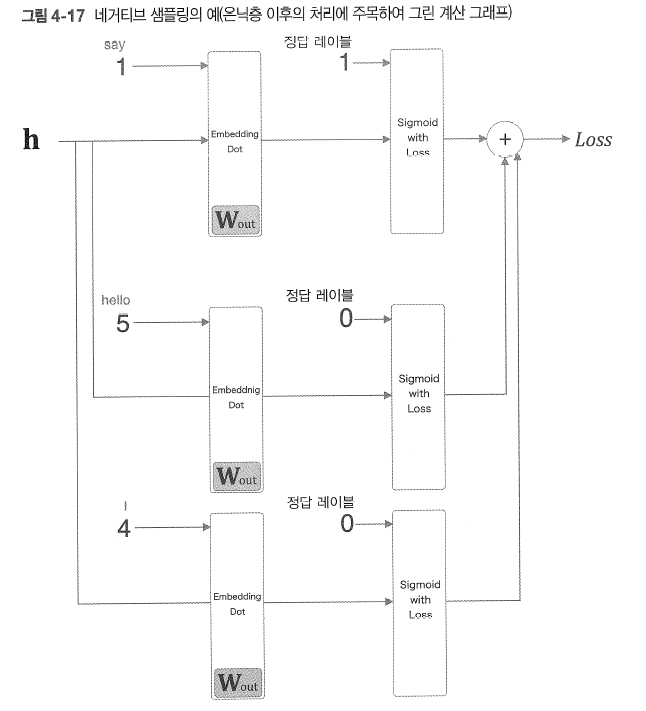

### 6) 네거티브 샘플링의 샘플링 기법
**말뭉치의 통계 데이터를 기초로 샘플링한다!**  
- 말뭉치에서 자주 등장하는 단어를 많이 추출, 드물게 등장하는 단어를 적게 추출  
- Step 1. 말뭉치에서 각 단어별 출현 횟수에 따라 확률분포를 구한다. 
- Step 2. 확률분포대로 단어를 샘플링 : **말뭉치에서 자주 등장하는 단어가 선택될 가능성 ↑**  
※ 부정적 예는 5개 or 10개 정도로 한정

In [10]:
# 확률분포에 따라 샘플링
import numpy as np

# 0에서 9까지의 숫자 중 하나를 무작위로 샘플링
print(np.random.choice(10))
print(np.random.choice(2))

7
1


In [11]:
# words에서 하나만 무작위로 샘플링
words = ['you','say','goodbye','I','hello','.']
np.random.choice(words)

'hello'

In [12]:
# 5개만 무작위로 샘플링(중복 가능)
np.random.choice(words,size = 5) #size : 샘플링을 size만큼 수행

array(['say', 'I', 'I', '.', 'hello'], dtype='<U7')

In [13]:
# 5개만 무작위로 샘플링(중복 불가)
np.random.choice(words,size = 5, replace = False) # replace = False : 샘플링 시 중복 없앰

array(['I', '.', 'hello', 'you', 'goodbye'], dtype='<U7')

In [14]:
# 확률분포에 따라 샘플링
p = [0.5,0.1,0.05,0.2,0.05,0.1]
np.random.choice(words, p= p)

'you'

#### 수정사항 : 기본 확률분포의 각 요소에 0.75(임의값)를 제곱하라!  
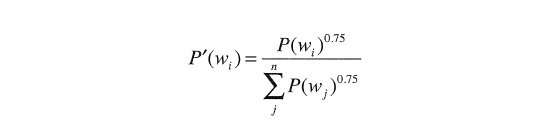

- 수정 후에도 확률의 총합 = 1 : 분모에도 수정 후 확률분포의 총합으로 수정!  
- 수정 이유 : **출현 확률이 낮은 단어를 버리지 않기 위해서**, 원래 확률이 낮은 단어의 확률을 조금 높일 수 있음  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : 낮은 확률의 단어가 좀 더 쉽게 샘플링되도록 하기 위함이다!

In [15]:
p = [0.7,0.29,0.01]
new_p = np.power(p,0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [18]:
# 네거티브 샘플링 처리
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

class UnigramSampler:  #유니그램 : 한 단어를 대상으로 확률분포를 만든다.
    def __init__(self, corpus, power, sample_size): # sample_size : 부정적 예 샘플링 수행 횟수
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target): # target 인수로 지정한 단어를 긍정적 예로 해석, 그 외의 부정적 예의 ID를 샘플링
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


In [19]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus,power,sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[0 2]
 [0 2]
 [4 2]]


긍정적 예 : [1,3,0]  
부정적 예 : 긍정적 예 각각에 대해 2개씩 샘플링, **실행마다 결과 변화**  
> - 첫 번째 데이터에 대한 부정적 예 : [0,2]
- 두 번째 데이터에 대한 부정적 예 : [0,2]
- 세 번째 데이터에 대한 부정적 예 : [4,2]


### 7) 네거티브 샘플링 구현

In [20]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5): # 출력 측 가중치 W
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        # sample_size + 1개의 계층 : sample_size(부정적 예를 다루는 계층) + 1(긍정적 예를 다루는 계층)
        # loss_layers[0]과 embed_dot_layers[0] : 긍정적 예를 다루는 계층

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

In [21]:
# 순전파 구현
def forward(self, h, target): # h : 은닉층 뉴런, target : 긍정적 예의 타깃
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target) # 부정적 예를 샘플링

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

**순전파 구현 : Embedding Dot 계층의 forward 점수 계산 ⇒ Sigmoid with Loss 계층으로 흘려 손실 계산**
- **긍정적 예의 정답 레이블(correct label) = "1"**  
- **부정적 예의 정답 레이블(negative label) = "0"**

In [22]:
# 역전파 구현
def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

## 3. 개선판 word2vec 학습

### 1) CBOW 모델 구현
앞 장의 SimpleCBOW 클래스를 **1) Embeddig 계층 2) Negative Sampling Loss 계층**을 적용해 개선

In [23]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus): # vocab_size : 어휘 수, window_size : 맥락의 크기
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

In [25]:
# 순전파와 역전파 처리
def forward(self, contexts, target): # 여기서 맥락과 타깃 : 단어 ID
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### 2) CBOW 모델 학습 코드

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장(pickle 기능 이용 : 파이썬 코드의 객체를 파일로 저장/읽기)
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

### 3) CBOW 모델 평가

In [34]:
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = './ch04/cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


#### word2vec으로 얻은 단어의 분산표현으로 "유추(비유) 문제" 풀기
- 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있음  

In [38]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [39]:
analogy('man','king','woman',word_to_id,id_to_word,word_vecs,top = 5)


[analogy] man:king = woman:?
 she: 4.1796875
 moody: 4.1328125
 share: 4.05078125
 character: 3.966796875
 chain: 3.912109375


In [40]:
# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875


#### take:took = go : "went" ⇒현재형과 과거형 패턴을 파악, 시제 정보가 단어의 분산 표현에 인코딩됨  
#### good:better = bad : "more"/"less" 등 ⇒ 정확한 답은 아니지만 비교급 성질도 단어의 분산 표현에 인코딩됨

## 4. word2vec 남은 주제
### 1) word2vec을 사용한 애플리케이션의 예
자연어 처리 분야에서 단어의 분산 표현이 중요한 이유 : **전이 학습(transfer learning)**  
- 먼저 큰 말뭉치로 학습을 끝낸 후 그 분산 표현을 각자의 작업에 이용  
<br>
<br>

단어의 분산 표현을 이용해 단어/문장을 고정 길이 벡터로 변환하는 방법 :**bag-of-words**
- 문장의 각 단어를 분산 표현으로 변환하고 그 합을 계산  
- 단어의 순서는 고려 X  
- 자연어를 벡터로 변환하면 신경망, SVM 등 머신러닝 기법 적용 가능!  
※ RNN을 사용해도 문장을 고정 길이 벡터로 변환 가능!

### 2) 단어 벡터 평가 방법
- 단어의 분산 표현의 차원 수가 최종 정확도에 어떤 영향을 주는지 조사하려면 두 단계 필요! **1) 단어의 분산 표현 학습 2) 머신러닝 시스템 학습**
⇒ 두 단계의 학습 수행 후 평가 : 시간이 오래 걸림
- 단어의 분산 표현 평가는 실제 애플리케이션(분류 시스템)과 분리해 평가!
- 평가 척도 : **'유사성'이나 '유추 문제'를 활용**  
A. 단어의 유사성 평가 : 사람이 작성한 단어 유사도를 검증 세트(word2vec에 의한 코사인 유사도 점수)를 사용해 상관성 검토  
B. 유추 문제를 활용한 평가 : 유추 문제를 출제하고 그 정답률로 분산 표현의 우수성 측정  
> "단어의 의미나 문법적 문제를 제대로 이해하고 있는지"를 측정 가능  

- **주의!**  
유추 문제에 의한 평가가 높다고 애플리케이션에서 반드시 좋은 결과가 나온다고 보장할 수 없다!  애플리케이션 종류, 말뭉치 내용 등 문제 상황에 따라 충분히 변동 가능!